In [70]:
import numpy as np
import pandas as pd
import pydot
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns=100
pd.options.display.max_rows=10

In [2]:
df_commits = pd.read_csv('E:\Apps\Desktop\commits.csv')
df_issues= pd.read_csv('E:\Apps\Desktop\issues.csv')

In [3]:
df_commits.head()

,key,cid,author_name,author_email,committer_name,committer_email,time,time_offset,tree_id,message_encoding
0,SPARK-16904,57626a55703a189e03148398f67c36cd0e557044,gatorsmile,gatorsmile@gmail.com,Reynold Xin,rxin@databricks.com,1478510197,-480,0f4ae99e29245041cae4d41f58aa208dba6beea4,[SPARK-16904][SQL] Removal of Hive Built-in Ha...
1,SPARK-18296,9db06c442cf85e41d51c7b167817f4e7971bf0da,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478501095,-480,e6325a24125325611506a7fc0119209b88be17e3,[SPARK-18296][SQL] Use consistent naming for e...
2,SPARK-18167,07ac3f09daf2b28436bc69f76badd1e36d756e4d,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478500925,-480,525bd0fd99741a6a0e2bcfdd5c4e074f839b92a5,[SPARK-18167][SQL] Disable flaky hive partitio...
3,SPARK-18173,46b2e499935386e28899d860110a6ab16c107c0c,Wenchen Fan,wenchen@databricks.com,Reynold Xin,rxin@databricks.com,1478487433,-480,a27367a0be38e5a8814aac6295387f0457c603c8,[SPARK-18173][SQL] data source tables should s...
4,SPARK-18269,556a3b7d07f36c29ceb88fb6c24cc229e0e53ee4,hyukjinkwon,gurwls223@gmail.com,Reynold Xin,rxin@databricks.com,1478487125,-480,ba48a84dc34757cd6691b6a7ce9abdb615c4c1ac,[SPARK-18269][SQL] CSV datasource should read ...


In [4]:
df_issues.head()

,key,jira_id,status_category,creator,priority,status,assignee,issuetype,reporter,resolution,project,updated,created,resolved,components,severity
0,SPARK-4957,12763687,Complete,nathan_gs,Major,Closed,None,Improvement,nathan_gs,None,Spark,2016-09-06T01:43:57.000+0000,2014-12-24T13:38:57.000+0000,2016-09-06T01:43:56.000+0000,Scheduler,3
1,SPARK-4956,12763679,Complete,liaoyuxi,Minor,Closed,None,Bug,liaoyuxi,None,Spark,2015-03-04T05:16:07.000+0000,2014-12-24T12:27:12.000+0000,2015-02-23T22:34:41.000+0000,MLlib,1
2,SPARK-4955,12763661,Complete,chengxiang li,Blocker,Closed,lianhuiwang,Bug,chengxiang li,None,Spark,2015-01-28T20:54:23.000+0000,2014-12-24T09:16:23.000+0000,2015-01-28T20:54:23.000+0000,YARN,10
3,SPARK-4954,12763657,Complete,liyezhang556520,Minor,Resolved,liyezhang556520,Improvement,liyezhang556520,None,Spark,2014-12-27T07:25:26.000+0000,2014-12-24T09:01:34.000+0000,2014-12-27T07:25:26.000+0000,Spark Core,1
4,SPARK-4953,12763643,Complete,sarutak,Major,Resolved,sarutak,Bug,sarutak,None,Spark,2014-12-25T15:06:12.000+0000,2014-12-24T07:07:56.000+0000,2014-12-25T15:06:12.000+0000,Documentation,3


In [5]:
df_result = pd.merge(df_commits, df_issues, on=['key'])
data = df_result[[ 'author_name','author_email','committer_name','committer_email','time', 'time_offset' , 'message_encoding' ,
                 'severity' ]] 

In [6]:
analyzed_data=pd.DataFrame(data=data, copy=True)

In [7]:
analyzed_data['time'] = pd.to_datetime(analyzed_data['time'], unit='s')

In [8]:
analyzed_data['time']=analyzed_data['time'].dt.to_period('D')

In [9]:
analyzed_data['time']=analyzed_data['time'].dt.to_timestamp()

In [10]:
analyzed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11475 entries, 0 to 11474
Data columns (total 8 columns):
author_name         11475 non-null object
author_email        11475 non-null object
committer_name      11475 non-null object
committer_email     11475 non-null object
time                11475 non-null datetime64[ns]
time_offset         11475 non-null int64
message_encoding    11475 non-null object
severity            11475 non-null int64
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 806.8+ KB


In [11]:
Days=pd.core.series.Series(data=analyzed_data['time'].unique())

In [12]:
Days

0      2016-11-07
1      2016-11-04
2      2016-11-01
3      2016-10-31
4      2016-10-29
          ...    
1103   2014-01-28
1104   2014-01-26
1105   2014-01-21
1106   2014-01-22
1107   2014-01-20
Length: 1108, dtype: datetime64[ns]

In [13]:
df = pd.DataFrame(columns=Days.values,index=data['committer_name'].unique())

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, Reynold Xin to CodingCat
Columns: 1108 entries, 2016-11-07 to 2014-01-20
dtypes: object(1108)
memory usage: 528.5+ KB


In [15]:
df.columns=df.columns.date

In [16]:
df

,2016-11-07,2016-11-04,2016-11-01,2016-10-31,2016-10-29,2016-11-06,2016-11-05,2016-11-02,2016-09-29,2016-11-03,2016-04-18,2016-06-01,2015-06-08,2014-12-05,2016-10-30,2016-10-21,2016-08-05,2016-10-28,2016-10-27,2016-09-21,2016-10-26,2016-03-10,2016-10-25,2016-09-27,2016-10-14,2016-10-24,2016-09-14,2016-10-23,2016-10-22,2016-04-08,2016-10-15,2016-08-09,2016-09-01,2016-10-20,2016-10-19,2016-10-18,2016-10-13,2016-10-11,2016-10-17,2016-10-16,2015-12-01,2016-10-03,2016-10-10,2016-09-30,2016-10-12,2016-10-07,2016-10-06,2016-10-05,2016-10-08,2016-09-26,...,2013-08-14,2013-08-19,2013-08-16,2013-08-22,2013-08-28,2013-09-08,2013-09-11,2013-09-12,2013-10-03,2013-10-05,2013-10-02,2013-10-04,2013-10-08,2013-09-27,2013-10-07,2013-10-17,2013-10-15,2013-10-19,2013-10-22,2013-10-25,2013-10-28,2013-10-27,2013-10-30,2013-11-24,2013-11-13,2013-11-25,2013-11-27,2013-11-26,2013-12-01,2013-11-28,2013-12-03,2013-11-29,2013-12-14,2013-12-12,2014-01-02,2014-01-09,2013-12-23,2013-12-09,2013-12-08,2014-01-04,2013-12-27,2013-12-30,2014-01-06,2014-01-08,2014-01-10,2014-01-28,2014-01-26,2014-01-21,2014-01-22,2014-01-20
Reynold Xin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yin Huai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yanbo Liang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sean Owen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Herman van Hovell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mark Hamstra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [17]:
for c in df.index:
    for d in df.columns:
        df.loc[c,d]=len(analyzed_data[(analyzed_data['committer_name'] == c)&(analyzed_data['time'] == d)])

In [18]:
df['Avarege']=df.mean(axis=1, skipna=True)

###### Среднее количество коммитов пользователей в день

In [19]:
df['Avarege'].head()

Reynold Xin          1.895307
Yin Huai             0.453971
Yanbo Liang          0.050542
Sean Owen            0.844765
Herman van Hovell    0.113718
Name: Avarege, dtype: float64

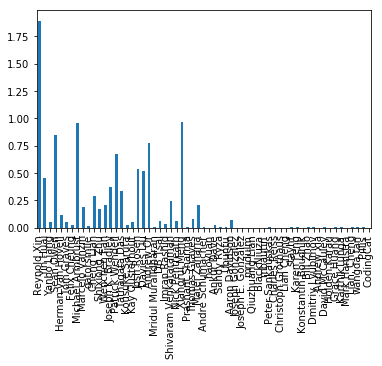

In [20]:
df['Avarege'].plot.bar();

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11475 entries, 0 to 11474
Data columns (total 8 columns):
author_name         11475 non-null object
author_email        11475 non-null object
committer_name      11475 non-null object
committer_email     11475 non-null object
time                11475 non-null int64
time_offset         11475 non-null int64
message_encoding    11475 non-null object
severity            11475 non-null int64
dtypes: int64(3), object(5)
memory usage: 806.8+ KB


In [22]:
lE=LabelEncoder()
lE.fit(data['committer_name'])
data['committer_name']=lE.transform(data['committer_name'])
lE.fit(data['committer_email'])
data['committer_email']=lE.transform(data['committer_email'])
lE.fit(data['author_name'])
data['author_name']=lE.transform(data['author_name'])
lE.fit(data['author_email'])
data['author_email']=lE.transform(data['author_email'])

E:\Apps\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Apps\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
E:\Apps\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11475 entries, 0 to 11474
Data columns (total 8 columns):
author_name         11475 non-null int64
author_email        11475 non-null int64
committer_name      11475 non-null int64
committer_email     11475 non-null int64
time                11475 non-null int64
time_offset         11475 non-null int64
message_encoding    11475 non-null object
severity            11475 non-null int64
dtypes: int64(7), object(1)
memory usage: 806.8+ KB


In [24]:
tfv = TfidfVectorizer(min_df=3,max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', 
                      ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
data['message_encoding']=tfv.fit_transform(data['message_encoding'])

E:\Apps\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
data.head()

,author_name,author_email,committer_name,committer_email,time,time_offset,message_encoding,severity
0,830,303,42,58,1478510197,-480,"(0, 51445)\t0.0351214801753\n (0, 53444)\t0...",3
1,566,787,42,58,1478501095,-480,"(0, 51445)\t0.0351214801753\n (0, 53444)\t0...",3
2,566,787,42,58,1478500925,-480,"(0, 51445)\t0.0351214801753\n (0, 53444)\t0...",3
3,201,260,54,80,1478300068,-420,"(0, 51445)\t0.0351214801753\n (0, 53444)\t0...",3
4,201,260,42,58,1478028934,-420,"(0, 51445)\t0.0351214801753\n (0, 53444)\t0...",3


In [26]:
Y= data['severity']

In [27]:
X=data.drop(['severity','message_encoding'], axis=1)

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=17)

In [29]:
first_tree = DecisionTreeClassifier(random_state=17)

In [30]:
np.mean(cross_val_score(first_tree, X_train, Y_train, cv=5))

0.49041032876585522

In [31]:
first_knn= KNeighborsClassifier()

In [32]:
np.mean(cross_val_score(first_knn, X_train, Y_train, cv=5))

0.47273662436726732

##### насраиваем макс глубину дерева

In [35]:
tree_params = {'max_depth': np.arange(1,11)}

In [36]:
tree_grid = GridSearchCV(first_tree, tree_params, cv=5)

In [37]:
%%time
tree_grid.fit(X_train, Y_train)

Wall time: 1.27 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
tree_grid.best_score_, tree_grid.best_params_

(0.57731573705179284, {'max_depth': 5})

##### насраиваем макс глубину соседей

In [39]:
knn_params = {'n_neighbors': list(range(5,30,5))+list(range(50,200, 5))}

In [40]:
knn_grid = GridSearchCV(first_knn, knn_params, cv=5)

In [41]:
%%time
knn_grid.fit(X_train, Y_train)

Wall time: 56.8 s


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 15, 20, 25, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
knn_grid.best_score_, knn_grid.best_params_

(0.55092131474103589, {'n_neighbors': 145})

##### Наиболее эффективная модель дерева

In [43]:
tree_valid_predict = tree_grid.predict(X_test)

In [71]:
confusion_matrix(Y_test, tree_valid_predict)

array([[   0,   54,  109,    0,    0],
       [   1,  180,  631,    0,    0],
       [   0,   96, 1809,    0,    2],
       [   0,   24,  249,    0,    1],
       [   0,    4,  281,    0,    2]], dtype=int64)

In [51]:
export_graphviz(tree_grid.best_estimator_,
                out_file='commits_tree.dot', feature_names=X.columns, filled=True)

In [69]:
!dot -Tpng commits_tree.dot -o commits_tree.png

<img src='commits_tree.png'>

# Сonclusion

So, the Decision trees model are working faster and more accurately than k-nearest neighbors model, because the second model has no learning, this model based on majority voting method, that means the unknown element will have same value as its most k-nearest neighbors have.